In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def forward(X,W1,b1,W2,b2):
    #sigmoid 
    z=1/(1+np.exp(-(X.dot(W1) + b1)))
    
    a=z.dot(W2)+b2
    expa=np.exp(a)
    y=expa/expa.sum(axis=1,keepdims=True)
    
    return y,z

In [3]:
def derivative_w1(X,Z,T,Y,W2):
    return X.T.dot( ( ( Y-T ).dot(W2.T) * ( Z*(1 - Z) ) ) )

In [4]:
def derivative_w2(Z,T,Y):
    return Z.T.dot(Y-T)

In [5]:
def derivative_b2(T,Y):
    return (Y-T).sum(axis=0)

In [6]:
def derivative_b1(Z, T, Y, W2):
     return (( Y-T ).dot(W2.T) * ( Z*(1 - Z) )).sum(axis=0) # for sigmoid

In [7]:
def y2indicator(y):
    n=len(y)
    y=y.astype(np.int32)
    k=y.max()+1
    ind=np.zeros((n,k))
    for n in range(n):
        k=y[n]
        ind[n,k]=1
    return ind

In [8]:
def cost(y_pred,y_true):
    tot=y_true*np.log(y_pred)
    return -tot.sum()

In [9]:
def predict(y_pred):
    return np.argmax(y_pred,axis=1)

In [10]:
def error_rate(y_pred,y_true):
    prediction=predict(y_pred)
    return np.mean(prediction!= y_true)

In [11]:
#this calculated the gradient of the weights
def gradw(y_true,y_pred,X):
    return X.T.dot(y_true-y_pred)

In [12]:
#this calculates the gradient of the biases
def gradb(y_true,y_pred):
    return (y_true-y_pred).sum(axis=0)

In [13]:
def get_normalized_data():
    df = pd.read_csv("/kaggle/input/mnist-in-csv/mnist_train.csv")
    data = df.values.astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    Y = data[:, 0]

    Xtrain = X[:-1000]
    Ytrain = Y[:-1000]
    Xtest  = X[-1000:]
    Ytest  = Y[-1000:]

    # normalize the data
    mu = Xtrain.mean(axis=0)
    std = Xtrain.std(axis=0)
    np.place(std, std == 0, 1)
    Xtrain = (Xtrain - mu) / std
    Xtest = (Xtest - mu) / std
    
    return Xtrain, Xtest, Ytrain, Ytest


In [14]:
def main():
    max_iter=30
    print_period=50
    
    x_train,x_test,y_train,y_test=get_normalized_data()
    lr=0.00004
    reg=0.01
    
    ytrain_ind=y2indicator(y_train)
    ytest_ind=y2indicator(y_test)
    
    N,D=x_train.shape
    batch_size=500
    n_batches=N//batch_size
    
    M=300
    K=10
    W1=np.random.randn(D,M)/np.sqrt(D)
    b1=np.zeros(M)
    W2=np.random.randn(M,K)/np.sqrt(D)
    b2=np.zeros(K)
    
    #save initial weights
    W1_0=W1.copy()
    b1_0=b1.copy()
    W2_0=W2.copy()
    b2_0=b2.copy()
    
    #1 batch
    losses_batch=[]
    error_batch=[]
    
    for i in range(max_iter):
        x_train,y_train,ytrain_ind=shuffle(x_train,y_train,ytrain_ind)
        for j in range(n_batches):
            xbatch=x_train[j*n_batches:(j+1)*n_batches,]
            ybatch=ytrain_ind[j*n_batches:(j+1)*n_batches,]
            pybatch,z=forward(xbatch,W1,b1,W2,b2)
            
            #gradient adjustment
            gw2=derivative_w2(z,ybatch,pybatch) + reg*W2
            gb2=derivative_b2(ybatch,pybatch) + reg*b2
            gw1=derivative_w1(xbatch,z,ybatch,pybatch,W2)+reg*W1
            gb1=derivative_b1(z,ybatch,pybatch,W2)+reg*b1
            
            
            #update the weigths
            W2-=lr*gw2
            b2-=lr*gb2
            W1-=lr*gw1
            b1-=lr*gb1
            
            if j%print_period==0:
                y_pred,_=forward(x_test,W1,b1,W2,b2)
                l=cost(y_pred,ytest_ind)
                losses_batch.append(l)
                print("cost at each iteration i=%d,j=%d:% .6f"%(i,j,l))
                
                e=error_rate(y_pred,y_test)
                error_batch.append(e)
                print("error rate:",e)
        y_pred,_=forward(x_test,W1,b1,W2,b2)
        print("final error rate: ",error_rate(y_pred,y_test))
    
    #2) batch with momentum 
    
    W1=W1_0.copy()
    b1=b1_0.copy()
    W2=W2_0.copy()
    b2=b2_0.copy()
    
    losses_momentum = []
    errors_momentum = []
    mu = 0.9
    dW2 = 0
    db2 = 0
    dW1 = 0
    db1 = 0
    
    for i in range(max_iter):
        x_train,y_train,ytrain_ind=shuffle(x_train,y_train,ytrain_ind)
        for j in range(n_batches):
            xbatch=x_train[j*n_batches:(j+1)*n_batches,]
            ybatch=ytrain_ind[j*n_batches:(j+1)*n_batches,]
            pybatch,z=forward(xbatch,W1,b1,W2,b2)
            
            #gradient adjustment
            gW2=derivative_w2(z,ybatch,pybatch) + reg*W2
            gb2=derivative_b2(ybatch,pybatch) + reg*b2
            gW1=derivative_w1(xbatch,z,ybatch,pybatch,W2)+reg*W1
            gb1=derivative_b1(z,ybatch,pybatch,W2)+reg*b1
            
            
            #update the velocities
            dW2 = mu*dW2 - lr*gW2
            db2 = mu*db2 - lr*gb2
            dW1 = mu*dW1 - lr*gW1
            db1 = mu*db1 - lr*gb1
            
            #update the weigths
            W2+=dW2
            b2+=db2
            W1+=dW1
            b1+=db1
            
            if j%print_period==0:
                y_pred,_=forward(x_test,W1,b1,W2,b2)
                l=cost(y_pred,ytest_ind)
                losses_batch.append(l)
                print("cost at each iteration i=%d,j=%d:% .6f"%(i,j,l))
                
                e=error_rate(y_pred,y_test)
                error_batch.append(e)
                print("error rate:",e)
        y_pred,_=forward(x_test,W1,b1,W2,b2)
        print("final error rate: ",error_rate(y_pred,y_test))
    
    #3) nestrov momentum
    
    W1 = W1_0.copy()
    b1 = b1_0.copy()
    W2 = W2_0.copy()
    b2 = b2_0.copy()

    losses_nesterov = []
    errors_nesterov = []
    
    mu = 0.9
    vW2 = 0
    vb2 = 0
    vW1 = 0
    vb1 = 0
    
    for i in range(max_iter):
        xtrain, ytrain, ytrain_ind = shuffle(x_train, y_train, ytrain_ind)
        for j in range(n_batches):
            Xbatch = x_train[j*batch_size:(j*batch_size + batch_size),]
            Ybatch = ytrain_ind[j*batch_size:(j*batch_size + batch_size),]
            pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)

            # updates
            gW2 = derivative_w2(Z, Ybatch, pYbatch) + reg*W2
            gb2 = derivative_b2(Ybatch, pYbatch) + reg*b2
            gW1 = derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1
            gb1 = derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1

            # v update
            vW2 = mu*vW2 - lr*gW2
            vb2 = mu*vb2 - lr*gb2
            vW1 = mu*vW1 - lr*gW1
            vb1 = mu*vb1 - lr*gb1

            # param update
            W2 += mu*vW2 - lr*gW2
            b2 += mu*vb2 - lr*gb2
            W1 += mu*vW1 - lr*gW1
            b1 += mu*vb1 - lr*gb1

            if j % print_period == 0:
                pY, _ = forward(x_test, W1, b1, W2, b2)
                l = cost(pY, ytest_ind)
                losses_nesterov.append(l)
                print("Cost at iteration i=%d, j=%d: %.6f" % (i, j, l))

                e = error_rate(pY, y_test)
                errors_nesterov.append(e)
                print("Error rate:", e)
    pY, _ = forward(x_test, W1, b1, W2, b2)
    print("Final error rate:", error_rate(pY, y_test))



    plt.plot(losses_batch, label="batch")
    plt.plot(losses_momentum, label="momentum")
    plt.plot(losses_nesterov, label="nesterov")
    plt.legend()
    plt.show()

cost at each iteration i=0,j=0: 2400.951208
error rate: 0.889
cost at each iteration i=0,j=50: 2242.236315
error rate: 0.77
cost at each iteration i=0,j=100: 2173.960881
error rate: 0.647
final error rate:  0.605
cost at each iteration i=1,j=0: 2148.008150
error rate: 0.609
cost at each iteration i=1,j=50: 2081.467572
error rate: 0.526
cost at each iteration i=1,j=100: 2016.021803
error rate: 0.444
final error rate:  0.428
cost at each iteration i=2,j=0: 1995.460929
error rate: 0.435
cost at each iteration i=2,j=50: 1931.909705
error rate: 0.387
cost at each iteration i=2,j=100: 1871.163913
error rate: 0.383
final error rate:  0.362
cost at each iteration i=3,j=0: 1848.892981
error rate: 0.361
cost at each iteration i=3,j=50: 1789.889542
error rate: 0.333
cost at each iteration i=3,j=100: 1732.814690
error rate: 0.337
final error rate:  0.312
cost at each iteration i=4,j=0: 1713.391613
error rate: 0.311
cost at each iteration i=4,j=50: 1656.525940
error rate: 0.289
cost at each iterati

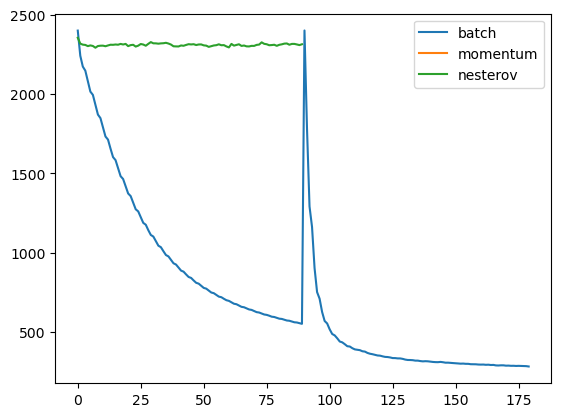

In [15]:
main()